# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Chuol Ruei Deng

*Semester:* Fall 2025

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
!pip install tensorflow

  Using cached tensorflow-2.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.76.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.7 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached h5py-3.15.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (3.0 kB)
  Using cached ml_dtypes-0.5.4-cp311-cp311-manylinux_

In [2]:
!pip install keras

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2025-12-16 20:37:37.517313: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 20:37:37.554751: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 20:37:38.820844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/srv/conda/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_v

In [4]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

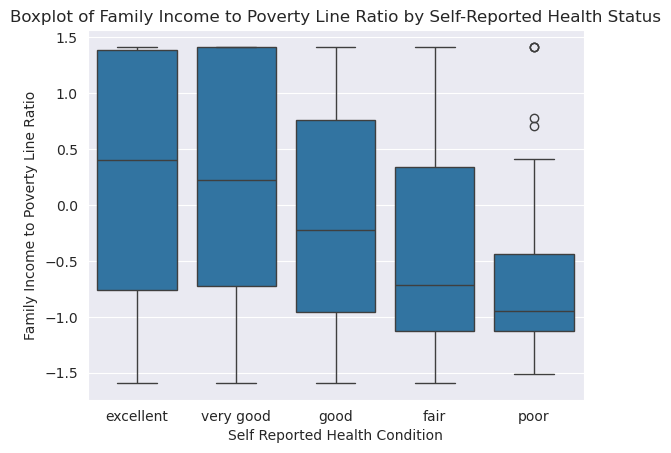

In [6]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

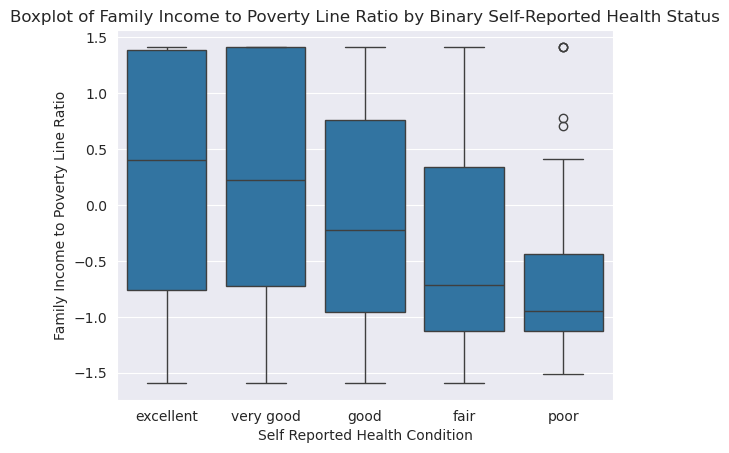

In [7]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

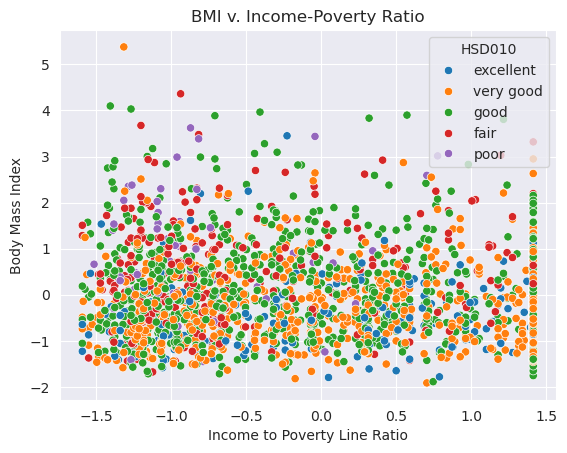

In [8]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [9]:
# Before we move to working on unsupervised methods, we'll drop our target variables again:
X_features = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis=1)

# Fit PCA with all components
pca = PCA()
pca.fit(X_features)

explained_variance = pca.explained_variance_ratio_

PCA was first fit using all available components to examine how variance is distributed across components. This allows the number of components to be chosen based on explained variance rather than an arbitrary cutoff.

### Barplot of Components

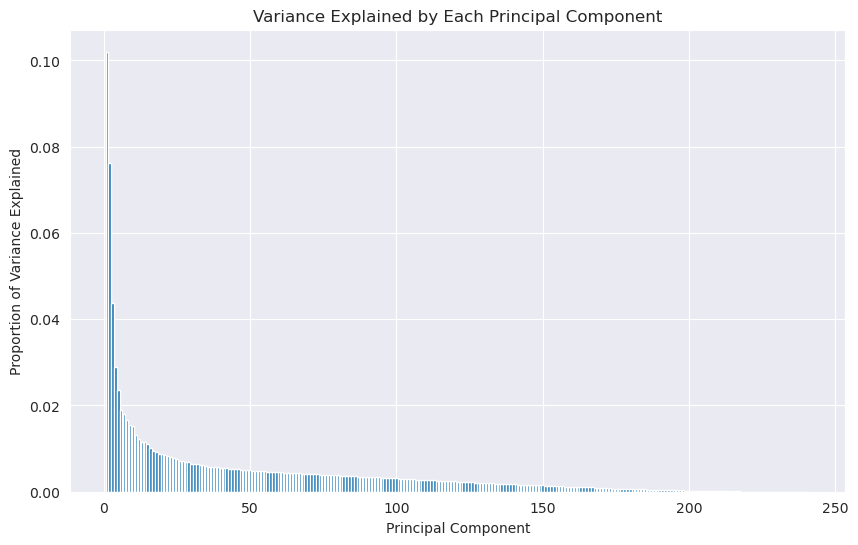

In [11]:
plt.figure(figsize=(10,6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.title("Variance Explained by Each Principal Component")
plt.show()

The barplot shows that the first few principal components explain a much larger share of the variance than later components, with diminishing gains as additional components are added.

### How many components will you use to fit a supervised learning model?

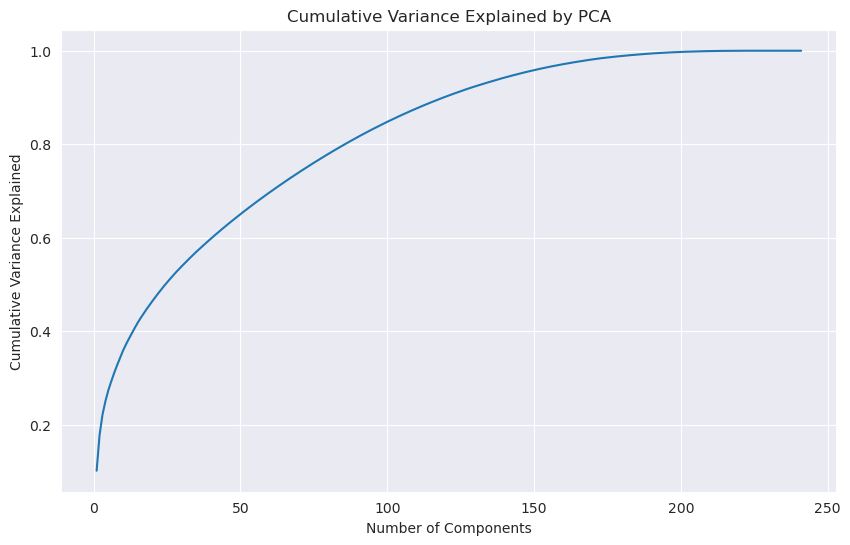

In [12]:
# Cumulative variance explained
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by PCA")
plt.show()

# Fit PCA keeping components that explain ~80% variance
num_components_80 = np.argmax(cumulative_variance >= 0.80) + 1

pca_reduced = PCA(n_components=num_components_80)
X_pca_reduced = pca_reduced.fit_transform(X_features)

I would retain the number of components needed to explain approximately 80 percent of the total variance. This threshold preserves most of the information in the data while substantially reducing dimensionality and the risk of overfitting in supervised learning.

### 2D Scatterplot of the first two components

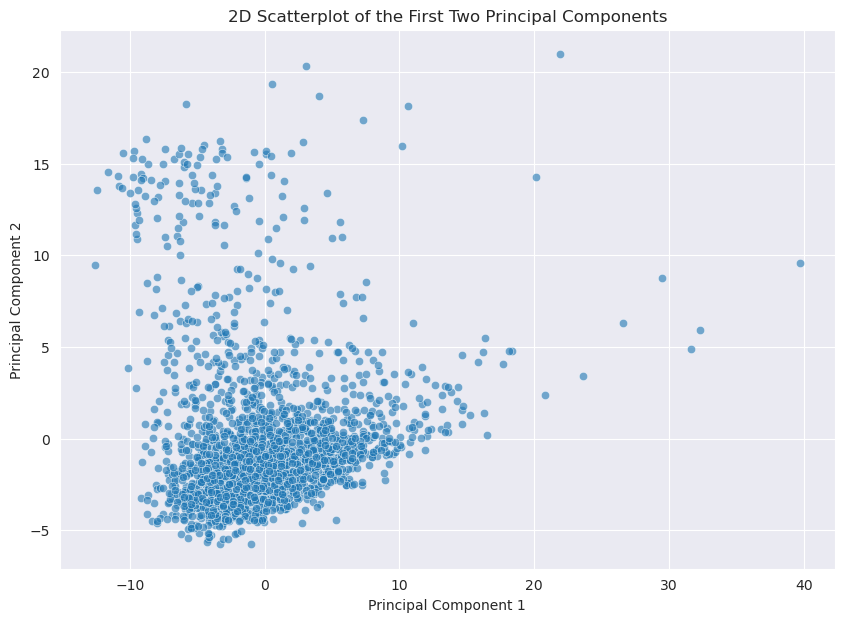

In [13]:
# Features only (drop target columns)
X_features = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis=1)

# PCA with two components
pca_2 = PCA(n_components=2)
pca_2_components = pca_2.fit_transform(X_features)

pca_df = pd.DataFrame(
    pca_2_components,
    columns=["Principal Component 1", "Principal Component 2"],
    index=nhanes_scaled.index
)

# Plot
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="Principal Component 1",
    y="Principal Component 2",
    data=pca_df,
    alpha=0.6
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D Scatterplot of the First Two Principal Components")
plt.show()

The scatterplot shows substantial overlap among observations, which reflects the heterogeneity of the NHANES population. The first principal component captures the largest overall variation in the data, while the second component represents an independent secondary pattern that adds structure but does not clearly separate individuals.

## Clustering

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I use k-means clustering, which partitions observations into groups by minimizing within cluster variance. It is computationally efficient and well suited for continuous, standardized variables such as those in the NHANES dataset.

### Cluster nhanes

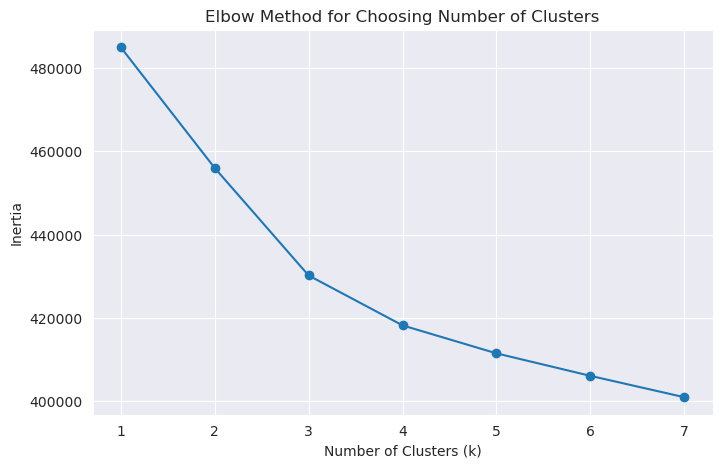

In [15]:
# Prepare features for clustering (drop target columns)
X_cluster = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis=1)

# Elbow method
inertia = []
K = range(1, 8)

for k in K:
    km = KMeans(n_clusters=k, n_init=10, random_state=10)
    km.fit(X_cluster)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Choosing Number of Clusters")
plt.show()

The elbow plot shows a clear reduction in inertia up to three clusters, after which the rate of improvement slows. This suggests that three clusters provide a reasonable balance between model simplicity and explanatory power.

In [16]:
# Fit KMeans with the chosen number of clusters
# Use 3 clusters as suggested by the elbow method
kmeans = KMeans(n_clusters=3, n_init=10, random_state=10)

# Fit the model on the features (without target columns) and get cluster labels
cluster_labels = kmeans.fit_predict(X_cluster)

# Add cluster labels to the scaled dataset
nhanes_scaled['cluster'] = cluster_labels

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

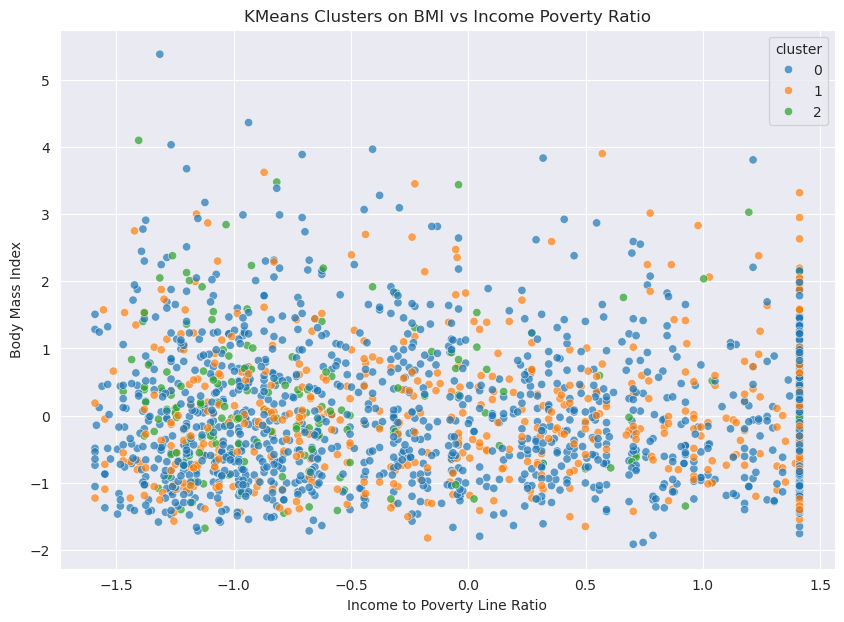

In [17]:
# Plot Clusters on BMI vs Income Poverty Ratio
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="INDFMPIR",
    y="BMXBMI",
    hue="cluster",
    palette="tab10",
    data=nhanes_scaled,
    alpha=0.7
)
plt.xlabel("Income to Poverty Line Ratio")
plt.ylabel("Body Mass Index")
plt.title("KMeans Clusters on BMI vs Income Poverty Ratio")
plt.show()

The clusters show partial separation along income and BMI, with one cluster concentrated at lower income levels and higher BMI. However, there is substantial overlap, indicating that BMI and income alone do not fully distinguish health related subgroups.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [20]:
# Prepare features for PCA (exclude target and cluster columns)
X_features = nhanes_scaled.drop(['HSD010', 'HSD010_binary', 'cluster'], axis=1)

# Fit PCA with 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_features)

pca_df = pd.DataFrame(
    pca_components,
    columns=["PC1", "PC2"],
    index=nhanes_scaled.index
)

# Fit k-means on PCA space
kmeans_pca = KMeans(n_clusters=3, n_init=10, random_state=10)
pca_df['cluster'] = kmeans_pca.fit_predict(pca_df)


In [21]:
pca_df.head()

,PC1,PC2,cluster
SEQN,,,
73568,9.527811,-0.816223,0
73576,-5.838338,-3.692575,1
73579,-0.719454,-2.573199,1
73581,3.533626,-2.576988,0
73584,-6.872094,-4.194237,1


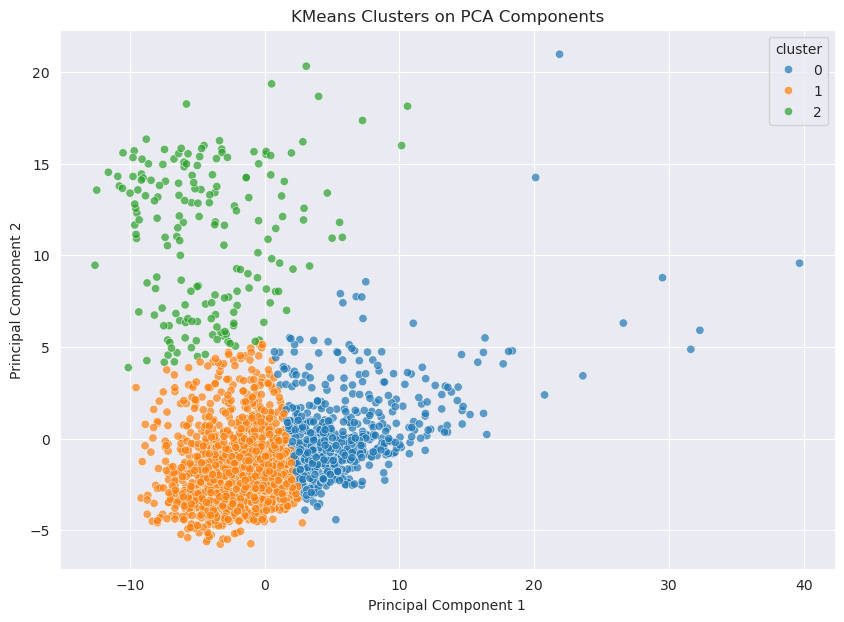

In [22]:
# Plot Clusters on 2D PCA Scatterplot
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="tab10",
    data=pca_df,
    alpha=0.7
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans Clusters on PCA Components")
plt.show()

Clustering in PCA space produces more visually distinct groupings than clustering on the original variables. This improvement reflects PCA’s ability to concentrate the most informative variation into fewer dimensions, making cluster structure easier to identify.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [23]:
# Define target and features
y = nhanes_scaled['HSD010_binary'].replace({'good': 0, 'poor': 1}).astype(int)
X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis=1)

# Partition data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=10
)

/tmp/ipykernel_1516/1746795509.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = nhanes_scaled['HSD010_binary'].replace({'good': 0, 'poor': 1}).astype(int)


In [24]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

# number of classes: binary classification (good vs poor)
num_classes = 2

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# confirm number of output classes
num_classes = y_test.shape[1]
print("Number of classes:", num_classes)

Number of classes: 2


In [25]:
# create neural network model
# -----------
from keras.models import Sequential
from keras.layers import Dense

# initialize the model
model = Sequential()

# input layer + first hidden layer
model.add(Dense(
    32,                           # number of neurons
    input_dim=X_train.shape[1],   # number of input features
    kernel_initializer='he_normal',
    activation='relu'
))

# second hidden layer
model.add(Dense(
    16,
    kernel_initializer='he_normal',
    activation='relu'
))

# output layer
model.add(Dense(
    num_classes,                  # number of output classes
    activation='softmax'          # softmax for probability output
))

# compile the model
model.compile(
    loss='categorical_crossentropy',  # loss function for multi-class classification
    optimizer='adam',                 # adaptive optimizer
    metrics=['accuracy']              # evaluation metric
)

# fit the model
model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=30, 
    batch_size=32, 
    verbose=1
)

Epoch 1/30


/srv/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-16 14:43:50.052111: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5446 - loss: 1.1207 - val_accuracy: 0.8043 - val_loss: 0.4874
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8327 - loss: 0.4188 - val_accuracy: 0.8469 - val_loss: 0.4027
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8676 - loss: 0.3357 - val_accuracy: 0.8527 - val_loss: 0.3832
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8889 - loss: 0.2862 - val_accuracy: 0.8702 - val_loss: 0.3615
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9089 - loss: 0.2472 - val_accuracy: 0.8585 - val_loss: 0.3647
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9199 - loss: 0.2188 - val_accuracy: 0.8566 - val_loss: 0.3661
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9399 - loss: 0.1888 - val_accuracy: 0.8547 - val_loss: 0.3629
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9438 - loss: 0.1665 - val_accuracy: 0.8508 - val_loss: 0.3756
Epo

### Neural Network on Principal Components

In [26]:
# Use the number of components that explain ~80% of variance
num_components_80 = np.argmax(cumulative_variance >= 0.80) + 1

# Transform features using PCA
pca_reduced = PCA(n_components=num_components_80)
X_pca_reduced = pca_reduced.fit_transform(X_features)

# Target variable (binary)
y = nhanes_scaled['HSD010_binary'].replace({'good': 0, 'poor': 1})

# Partition data
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_reduced, y, test_size=0.25, random_state=10
)

# One-hot encode the target
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
num_classes = y_train.shape[1]

# Neural network model
model = Sequential()

# Input layer + first hidden layer
model.add(Dense(
    32,
    input_dim=X_train.shape[1],
    kernel_initializer='he_normal',
    activation='relu'
))

# Second hidden layer
model.add(Dense(
    16,
    kernel_initializer='he_normal',
    activation='relu'
))

# Output layer
model.add(Dense(
    num_classes,
    activation='softmax'
))

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Fit model
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30


/tmp/ipykernel_1516/3001432843.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = nhanes_scaled['HSD010_binary'].replace({'good': 0, 'poor': 1})
/srv/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3256 - loss: 1.5984 - val_accuracy: 0.6008 - val_loss: 0.7713
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7326 - loss: 0.6177 - val_accuracy: 0.8159 - val_loss: 0.4945
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8282 - loss: 0.4506 - val_accuracy: 0.8430 - val_loss: 0.4275
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8508 - loss: 0.3844 - val_accuracy: 0.8566 - val_loss: 0.3942
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8689 - loss: 0.3469 - val_accuracy: 0.8624 - val_loss: 0.3763
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8792 - loss: 0.3192 - val_accuracy: 0.8605 - val_loss: 0.3669
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8857 - loss: 0.3006 - val_accuracy: 0.8624 - val_loss: 0.3609
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8863 - loss: 0.2838 - val_accuracy: 0.8624 - val_loss: 0.3573
Epo

### Neural Network on Principal Components + Cluster Membership

In [28]:
# -------------------------------
# Load and preprocess NHANES data
# -------------------------------
nhanes = pd.read_csv('nhanes.csv')

# Keep IDs and target
seqn = nhanes['SEQN']
hsd010 = nhanes['HSD010']

# Drop ID and target for scaling
nhanes_features = nhanes.drop(['SEQN', 'HSD010'], axis=1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes_features),
                             columns=nhanes_features.columns)

# Add target and ID back
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled['SEQN'] = seqn
nhanes_scaled = nhanes_scaled.set_index('SEQN')

# Create binary target
nhanes_scaled['HSD010_binary'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good','good','good','poor','poor']
)

# -------------------------------
# PCA
# -------------------------------
# Drop target columns for PCA
X_features = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis=1)

# Fit PCA to retain ~90% variance
pca_full = PCA()
pca_full.fit(X_features)
cumulative_variance = pca_full.explained_variance_ratio_.cumsum()
num_pca_components = (cumulative_variance < 0.9).sum() + 1

# Transform features
pca = PCA(n_components=num_pca_components)
X_pca = pca.fit_transform(X_features)

# -------------------------------
# KMeans clustering
# -------------------------------
# Fit KMeans
kmeans = KMeans(n_clusters=3, n_init=10, random_state=10)
clusters = kmeans.fit_predict(X_features)

# Combine PCA components and cluster labels as new features
import numpy as np
X_combined = np.hstack([X_pca, clusters.reshape(-1,1)])

# -------------------------------
# Target
# -------------------------------
y = nhanes_scaled['HSD010_binary'].replace({'good': 0, 'poor': 1})

# -------------------------------
# Train/test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.25, random_state=10
)

# One-hot encode target
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
num_classes = y_train.shape[1]

# -------------------------------
# Neural network
# -------------------------------
model = Sequential()

# Input layer + first hidden layer
model.add(Dense(
    32,
    input_dim=X_train.shape[1],
    kernel_initializer='he_normal',
    activation='relu'
))

# Second hidden layer
model.add(Dense(
    16,
    kernel_initializer='he_normal',
    activation='relu'
))

# Output layer
model.add(Dense(
    num_classes,
    activation='softmax'
))

# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Fit model
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30


/tmp/ipykernel_1516/3776996806.py:55: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = nhanes_scaled['HSD010_binary'].replace({'good': 0, 'poor': 1})
/srv/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7358 - loss: 0.5898 - val_accuracy: 0.8450 - val_loss: 0.4553
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8417 - loss: 0.4144 - val_accuracy: 0.8508 - val_loss: 0.4068
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8682 - loss: 0.3411 - val_accuracy: 0.8527 - val_loss: 0.3856
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8831 - loss: 0.2938 - val_accuracy: 0.8605 - val_loss: 0.3792
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8986 - loss: 0.2565 - val_accuracy: 0.8605 - val_loss: 0.3767
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9121 - loss: 0.2251 - val_accuracy: 0.8605 - val_loss: 0.3798
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9225 - loss: 0.1981 - val_accuracy: 0.8508 - val_loss: 0.3919
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9354 - loss: 0.1751 - val_accuracy: 0.8566 - val_loss: 0.3976
Epo

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

Principal Component Analysis, or PCA, is a technique used to reduce the dimensionality of data. It identifies new directions, called principal components, along which the data varies the most. Essentially, PCA transforms the original features into a smaller set of uncorrelated components that capture most of the information in the dataset. It does not try to group the data, but rather to simplify it while preserving variance.

Clustering, on the other hand, is a method for grouping data points based on similarity. Algorithms like k-means assign each observation to a cluster such that points within the same cluster are more similar to each other than to points in other clusters. Clustering does not reduce the number of features, but it creates structure in the data by identifying patterns or subgroups.

In short, PCA is about reducing complexity and highlighting the directions of maximum variation, while clustering is about organizing data into meaningful groups.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Combining PCA and clustering can offer several advantages. PCA reduces the number of features while keeping most of the important information. By doing so, it removes noise and redundant variables that could mislead a clustering algorithm. When clustering is applied to the principal components instead of the raw data, it often finds cleaner, more meaningful clusters because the data is more compact and less noisy.

In our assignment, combining PCA with clustering allowed us to create new features, including the cluster membership, which could then be used in a neural network. This often improves predictive performance because the model receives additional information about underlying patterns in the data that may not be obvious from the original features alone. If no gains were observed, it could be due to the fact that the clusters did not capture much additional structure beyond what PCA already represented, or because the dataset was already well-represented by the principal components.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques like PCA and clustering are extremely helpful when dealing with large and complex datasets. PCA reduces dimensionality, which makes training supervised models faster and less prone to overfitting, especially when the number of features is very high. Clustering can uncover hidden structures or subgroups in the data that can be used as additional features, helping supervised models capture more nuanced patterns.

Overall, unsupervised methods act as a preprocessing step that simplifies and enriches the data. They make it easier for supervised models to learn meaningful relationships, improve accuracy, reduce computational cost, and help with interpreting results. In the context of "big data," where datasets can have thousands of features and millions of observations, these techniques are almost essential for effective machine learning.